In [ ]:
!pip install deap
from deap import base
from deap import creator
from deap import tools

import numpy as np
import random
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from IPython.display import display, clear_output

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Выбор параметров для алгоритма:


In [ ]:
# Genetic Algorithm constants:
POPULATION_SIZE = 30
P_CROSSOVER = 0.8  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 70 # length of bit string to be optimized

# problem constants:
DIMENSIONS = 2  # number of dimensions
BOUND_LOW, BOUND_UP = -100.0, 100.0  # boundaries for all dimensions
HALL_OF_FAME_SIZE = 10
CROWDING_FACTOR = 0.4  # crowding factor for crossover and mutation

# Early stopping
USE_DELTA = True
MAX_DELTA = 0.01  # max result delta 
MEAN_DELTA = 0.01  # mean result delta 
N_DELTA_GENERATIONS = 10  # number of generations < MAX_DELTA to stop

# Определение используемых функций:



In [ ]:
toolbox = base.Toolbox()

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

# helper function for creating random real numbers uniformly distributed within a given range [low, up]
# it assumes that the range is the same for every dimension
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

# create an operator that randomly returns a float in the desired range and dimension:
toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation:
# compute the fitness function
def functionFitness(individual):
  x = individual[0]
  y = individual[1]
  f = np.power((x**2 + y**2), 0.25) * np.sin(50*np.power((x**2 + y**2), 0.1)+1)**2
  return f ,  # return a tuple


toolbox.register("evaluate", functionFitness)

# genetic operators:

# Using selection function:
toolbox.register("selectTournament", tools.selTournament, tournsize=2)
toolbox.register("selectBest", tools.selBest)
toolbox.register("selectRandom", tools.selRandom)

# Single-point crossover: 
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
# toolbox.register("mate", tools.cxBlend, alpha=0.5)

# Flip-bit mutation:
# indpb: Independent probability for each attribute to be changed
toolbox.register("mutate",  tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=1.0/DIMENSIONS)

# Цикл алгоритма:


 

In [ ]:
# Genetic Algorithm flow:

# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)
generationCounter = 0

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# calculate fitness tuple for each individual in the population:
fitnessValues = list(map(toolbox.evaluate, population))
for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.values = fitnessValue

# initialize statistics accumulators:
bestIndividuals = []
minFitnessValues = []
meanFitnessValues = []

all_Individuals = []
all_FitnessValues = []


# main evolutionary loop:
# stop if max fitness value reached the known max value
# OR if number of generations exceeded the preset value:
stop_delta_flag = False
delta_generations = 0
while generationCounter < MAX_GENERATIONS and not stop_delta_flag:
    # update counter:
    generationCounter = generationCounter + 1

    # apply the selection operator, to select the next generation's individuals:
    offspring = toolbox.selectTournament(population, POPULATION_SIZE)
    # clone the selected individuals:
    offspring = list(map(toolbox.clone, offspring))
    random.shuffle(offspring)

    # apply the crossover operator to pairs of offspring:
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # calculate fitness for the individuals with no previous calculated fitness value:
    freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
    freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
    for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
        individual.fitness.values = fitnessValue

    # replace the current population with the offspring:
    population[:] = offspring
    # population_offspring = population + offspring
    # population[:] = toolbox.selectBest(population_offspring, round(POPULATION_SIZE*0.1)) \
    #  + toolbox.selectTournament(population_offspring, round(POPULATION_SIZE*0.5)) \
    #  + toolbox.selectRandom(population_offspring, round(POPULATION_SIZE*0.4))


    # collect fitnessValues into a list, update statistics and print:
    individuals = list(population)
    all_Individuals += [individuals]
    fitnessValues = [ind.fitness.values[0] for ind in population]
    all_FitnessValues += [fitnessValues]

    minFitness = min(fitnessValues)
    meanFitness = sum(fitnessValues) / len(population)
    minFitnessValues.append(minFitness)
    meanFitnessValues.append(meanFitness)
    # print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter, minFitness, meanFitness))

    # find and print best individual:
    best_individual_index = fitnessValues.index(min(fitnessValues))
    best_individual = individuals[best_individual_index]
    bestIndividuals.append(best_individual)
    # print("Best Individual = ", individuals[best_individual_index])
    # print("Unique individuals = ", len(set(individuals)), "\n")

    hof.update(population)

    if USE_DELTA:
        if generationCounter > N_DELTA_GENERATIONS:
          if abs(minFitnessValues[-2] - minFitnessValues[-1]) < MAX_DELTA and \
          abs(meanFitnessValues[-2] - meanFitnessValues[-1]) < MEAN_DELTA:
            delta_generations += 1
          else:
            delta_generations = 0
          if delta_generations == N_DELTA_GENERATIONS:
            stop_delta_flag = True
            print('Early stopping: ', generationCounter)


Глобальный максимум функции: 0 при x1 и х2 = 0


In [ ]:
print("Min Fitness =", round(hof.items[0].fitness.values[0], 7)) 
print("Best x = ", hof.items[0])

Min Fitness = 0.0001855
Best x =  [0.6334051100951967, -22.54371894313725]


# Графики

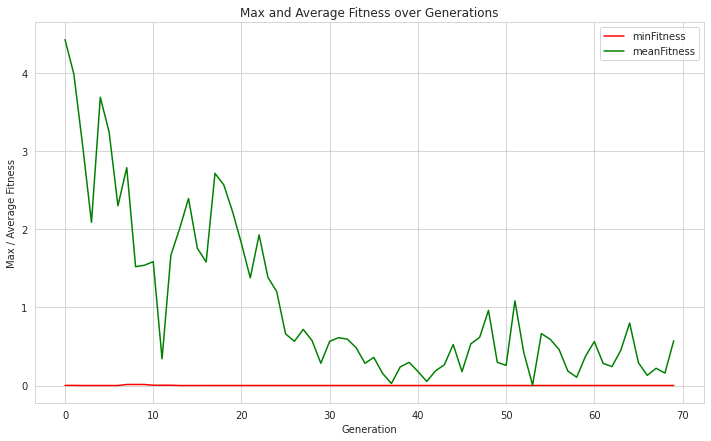

In [ ]:
# Genetic Algorithm is done - plot statistics:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(minFitnessValues, color='red', label='minFitness')
plt.plot(meanFitnessValues, color='green', label='meanFitness')
plt.legend()
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

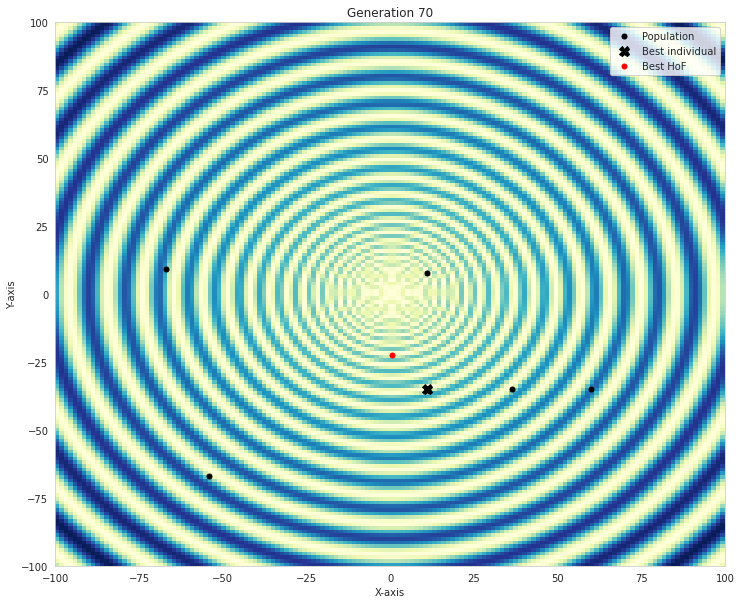

In [ ]:
xy = np.linspace(-100, 100, 150)
X,Y = np.meshgrid(xy, xy)
Z = functionFitness((X, Y))[0].T

fig, ax = plt.subplots(figsize=(12, 10))
for i in range(0,generationCounter, 3):
    ax.cla()
    ax.pcolor(X, Y, Z, cmap=cm.YlGnBu)
    ax.plot([sub[0] for sub in all_Individuals[i]], [sub[1] for sub in all_Individuals[i]], 'ko', markersize=5,  label='Population')
    ax.plot(bestIndividuals[i][0], bestIndividuals[i][1], 'kX', markersize=10, label='Best individual')
    ax.plot(hof.items[0][0], hof.items[0][1], 'r.', markersize=10, label='Best HoF')
    # fig.colorbar(p, ax=ax)

    # setting labels
    plt.legend()
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Generation "+str(i+1))

    display(fig)    
    time.sleep(0.8)
    clear_output(wait = True)